<a href="https://colab.research.google.com/github/rgkamakshi/ML-challenge/blob/main/ML_challenge_Ausgrid_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we have the entire workflow of our project starting with data preprocessing, exploratory data analysis,  data preparation, Model training( we tried 2 models SARIMA and XGBoost) and Model evaluation

# Time series forecasting
Ausgrid is one of the major electricity distributors in Australia. The company plays a crucial role in managing and distributing electricity to residential, commercial, and industrial consumers within its service area. The challenge is to develop a robust forecasting model that can predict energy consumption. The prediction ensures a proper control of the energy that will be supplied to the users resulting in optimal energy management.


The goal of the project is to predict the net household energy consumption using time series forecasting.

Dataset - We have used the solar homes monthly datset from Ausgrid with 2657 records. (Add URL)

Target variable -> Net Household Consumption = Total Grid Consumption - Solar Power Output


### Getting started - Data exploration

In [1]:
! pip3 install statsmodels

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('once')
%matplotlib inline

In [3]:
# Upload data
from google.colab import files
solar_data = files.upload()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving SolarMonthlyData_2657Custs.csv to SolarMonthlyData_2657Custs.csv


In [4]:
import io
solar_data = pd.read_csv(io.BytesIO(solar_data['SolarMonthlyData_2657Custs.csv']))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

In [5]:
solar_data.head()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me
0,1,SC,1.2007,31.0,DAY
1,1,SC,1.2008,31.0,DAY
2,1,SC,1.2009,31.0,DAY
3,1,SC,1.2010,31.0,DAY
4,1,PK,1.2011,31.0,DAY


Selecting only rows that are related to energy consumption from grid









In [6]:
# ======================================================================================
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2','SC']
solar_data_consumption = solar_data[(solar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].astype('str')
solar_data_consumption['Consumption Month'] = pd.to_datetime(solar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
#solar_data_consumption['house_type'] = 'solar'
solar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me
95,1,SC,2007-01-01,422.167,KWH
96,1,OP1,2007-01-01,168.073,KWH
97,1,OP1,2008-01-01,145.746,KWH
98,1,SC,2008-01-01,556.769,KWH
99,1,OP1,2009-01-01,189.888,KWH


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

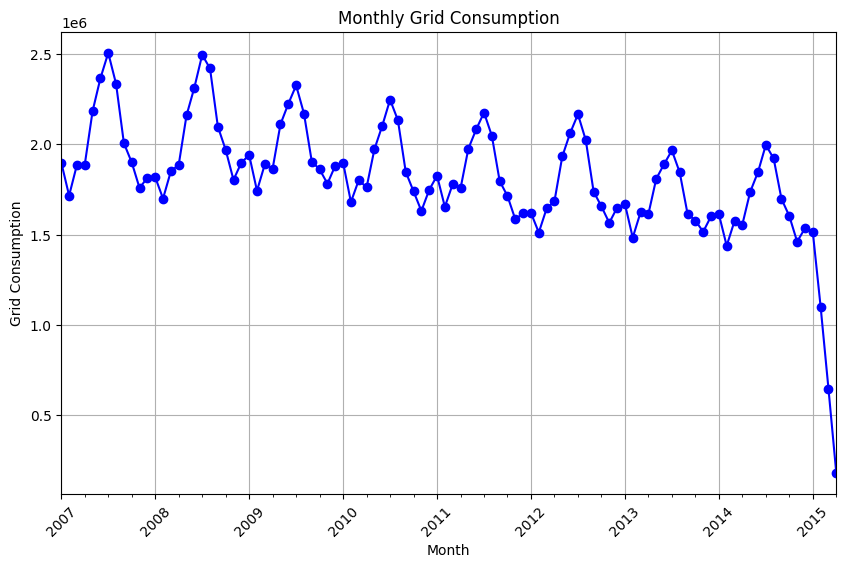

In [7]:
monthly_grid_consumption = solar_data_consumption.groupby('Consumption Month')['Sum'].sum()

# Plot the line chart
plt.figure(figsize=(10, 6))
monthly_grid_consumption.plot(kind='line', marker='o', color='b')
plt.title('Monthly Grid Consumption')
plt.xlabel('Month')
plt.ylabel('Grid Consumption')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

:
Selecting rows that are related to energy generated from solar

In [8]:
generation_billrate = ['PGR', 'SGR','OGR','OGG','PGG','SGG']
solar_data_generation = solar_data[(solar_data['Netwk Bill Rate Type'].isin(generation_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_generation['Consumption Month'] = solar_data_generation['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_generation['Consumption Month'] = solar_data_generation['Consumption Month'].astype('str')
solar_data_generation['Consumption Month'] = pd.to_datetime(solar_data_generation['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
solar_data_generation.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me
104,1,OGR,2011-01-01,2.060,KWH
107,1,SGR,2011-01-01,411.840,KWH
109,1,PGR,2011-01-01,131.230,KWH
113,1,OGR,2012-01-01,2.031,KWH
115,1,PGR,2012-01-01,116.147,KWH


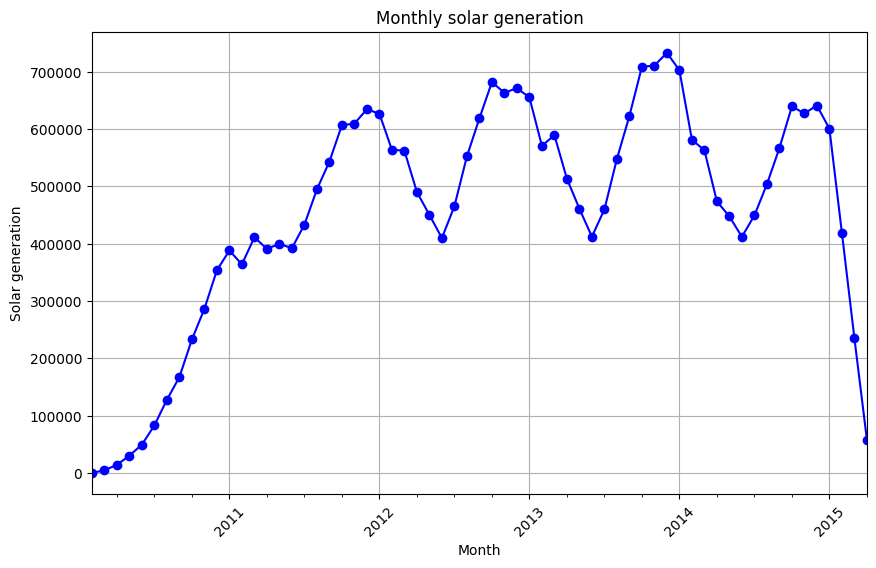

In [9]:
monthly_solar_generation = solar_data_generation.groupby('Consumption Month')['Sum'].sum()

# Plot the line chart
plt.figure(figsize=(10, 6))
monthly_solar_generation.plot(kind='line', marker='o', color='b')
plt.title('Monthly solar generation')
plt.xlabel('Month')
plt.ylabel('Solar generation')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [10]:
solar_gross_consumption = solar_data_consumption.groupby(['Customer ID', 'Consumption Month']).agg(consumption = ('Sum','sum'))
solar_gross_generation = solar_data_generation.groupby(['Customer ID', 'Consumption Month']).agg(consumption = ('Sum','sum')).reset_index()


In [11]:
solar_gross_consumption.head()

consumption
Customer ID Consumption Month             
1           2007-01-01             590.240
            2007-02-01             670.667
            2007-03-01             742.524
            2007-04-01             786.290
            2007-05-01            1092.402

In [12]:
solar_gross_generation.head()

,Customer ID,Consumption Month,consumption
0,1,2010-05-01,122.796
1,1,2010-06-01,245.592
2,1,2010-07-01,276.115
3,1,2010-08-01,426.897
4,1,2010-09-01,413.127


In [13]:
solar_net_consumption = solar_gross_consumption.merge(solar_gross_generation, on = ['Customer ID', 'Consumption Month'], how = 'left',suffixes=('_left', '_right'))
solar_net_consumption['consumption'] = solar_net_consumption.fillna(0)['consumption_left'] - solar_net_consumption.fillna(0)['consumption_right']
solar_net_consumption = solar_net_consumption[['Customer ID', 'Consumption Month', 'consumption']].copy()
solar_net_consumption.head()


,Customer ID,Consumption Month,consumption
0,1,2007-01-01,590.240
1,1,2007-02-01,670.667
2,1,2007-03-01,742.524
3,1,2007-04-01,786.290
4,1,2007-05-01,1092.402


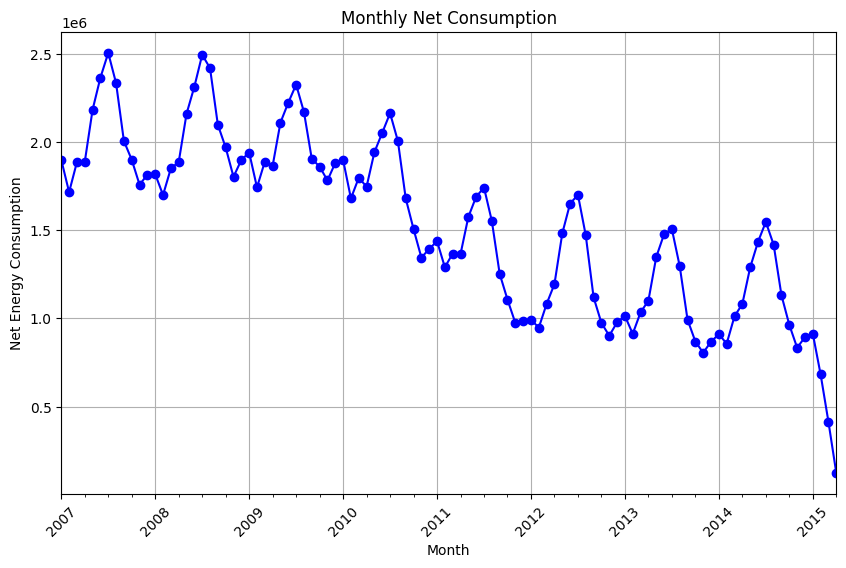

In [14]:
monthly_net_consumption = solar_net_consumption.groupby('Consumption Month')['consumption'].sum()
# Plot the line chart
plt.figure(figsize=(10, 6))
monthly_net_consumption.plot(kind='line', marker='o', color='b')
plt.title('Monthly Net Consumption')
plt.xlabel('Month')
plt.ylabel('Net Energy Consumption')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

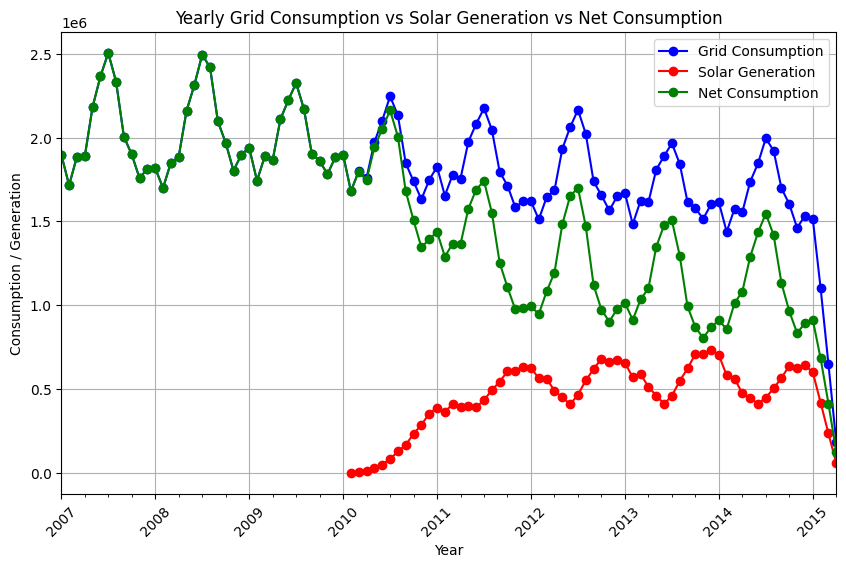

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [15]:

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first line chart (Grid Consumption)
monthly_grid_consumption.plot(kind='line', marker='o', color='b', ax=ax, label='Grid Consumption')

# Plot the second line chart (Solar Generation)
monthly_solar_generation.plot(kind='line', marker='o', color='r', ax=ax, label='Solar Generation')

# Plot the third line chart (net Consumption)
monthly_net_consumption.plot(kind='line', marker='o', color='g', ax=ax, label='Net Consumption')


# Add title, labels, legend, and grid
plt.title('Yearly Grid Consumption vs Solar Generation vs Net Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption / Generation')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show plot
plt.show()

Look at the customer countdistribution of data over time

In [16]:
solar_net_consumption['Consumption Month'].value_counts().sort_index()

Consumption Month
2007-01-01    2654
2007-02-01    2650
2007-03-01    2650
2007-04-01    2650
2007-05-01    2653
              ... 
2014-12-01    2450
2015-01-01    2446
2015-02-01    2275
2015-03-01    1529
2015-04-01     547
Name: count, Length: 100, dtype: int64

In [17]:
customer_periods = solar_net_consumption.groupby('Customer ID')['Consumption Month'].count().sort_values(ascending=False).reset_index()
customer_periods.head(10)

,Customer ID,Consumption Month
0,1429,100
1,1306,100
2,1168,100
3,1169,100
4,1170,100
5,1172,100
6,1173,100
7,1174,100
8,1175,100
9,1177,100


In [18]:
customer_cohorts = customer_periods.groupby(['Consumption Month']).agg(customer_count = ('Customer ID','count')).sort_index(ascending=False).reset_index()
customer_cohorts.head()

,Consumption Month,customer_count
0,100,538
1,99,971
2,98,741
3,97,176
4,96,9


In [20]:
customer_cohorts.sort_values(['customer_count'],ascending=False).head()

,Consumption Month,customer_count
1,99,971
2,98,741
0,100,538
3,97,176
6,94,116


There are 538 customers with energy consumption data for the entire period (100 months), whereas most customers (971 of them) have data for one month less.

Now, let look at the distribution excluding 2015 values.


In [21]:
customer_periods_until_2014 = solar_net_consumption[solar_net_consumption['Consumption Month'] < '2015-01-01'].groupby('Customer ID')['Consumption Month'].count().sort_values(ascending=False).reset_index()
customer_cohorts_until_2014 = customer_periods_until_2014.groupby(['Consumption Month']).agg(customer_count = ('Customer ID','count')).sort_index(ascending=False).reset_index()
customer_cohorts_until_2014.head()

,Consumption Month,customer_count
0,96,2410
1,95,68
2,94,120
3,93,13
4,92,30


The above shows that most of the customers have consumption data until 2014. We can safely exclude 2015 data. This is also evident from the below graph.




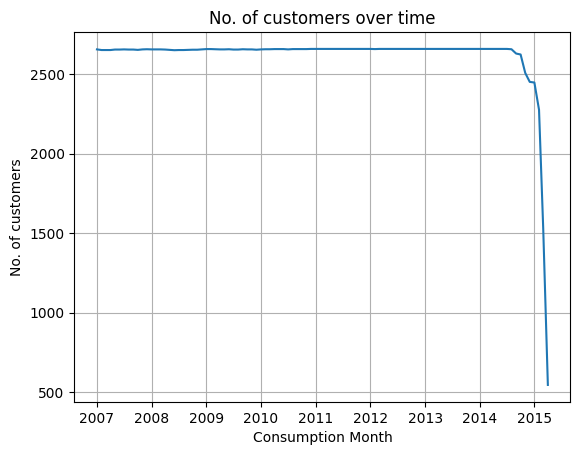

In [22]:
grouped_counts = solar_net_consumption.groupby('Consumption Month')['Customer ID'].count()
grouped_counts_df = grouped_counts.reset_index()

plt.plot(grouped_counts_df['Consumption Month'], grouped_counts_df['Customer ID'])

plt.xlabel('Consumption Month')
plt.ylabel('No. of customers')
plt.title('No. of customers over time')

plt.grid(True)
plt.show()

## Single series forecasting with SARIMA
Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting. SARIMA (Seasonal Auto-Regressive Integrated Moving Average) is an extension of the ARIMA model that incorporates seasonality in addition to the non-seasonal components.

Let's forecast at the aggregate level for each month. This represents a single series. If we want to forecast for each customer independently, we need to employ models that support multiseries forecasting (like Vector Autoregression, Multivariate LSTM, ensemble models etc.).
Or we need to create a separate model for each series independently, with univariate approaches like ARIMA.




In [23]:
# Aggregate net consumption for each month until 2014
solar_data_grouped = solar_net_consumption[solar_net_consumption['Consumption Month'] < '2015-01-01'].groupby(['Consumption Month']).agg(consumption = ('consumption','sum')).reset_index()
solar_data_grouped.columns = ['month', 'consumption']


In [24]:
# Set the month as index for forecasting
solar = solar_data_grouped.set_index('month')
solar.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,consumption
month,
2007-01-01,1898849.965
2007-02-01,1715868.906
2007-03-01,1886211.485
2007-04-01,1887415.309
2007-05-01,2182928.883


Check for stationarity

The Time series data model works on stationary data. The stationarity of data is described by the following three criteria:-

    It should have a constant mean

    It should have a constant variance

    Auto covariance does not depend on the time

*Mean – it is the average value of all the data

*Variance – it is a difference of each point value from the mean

*Auto covariance –it is a relationship between any two values at a certain amount of time.

<Axes: xlabel='month'>

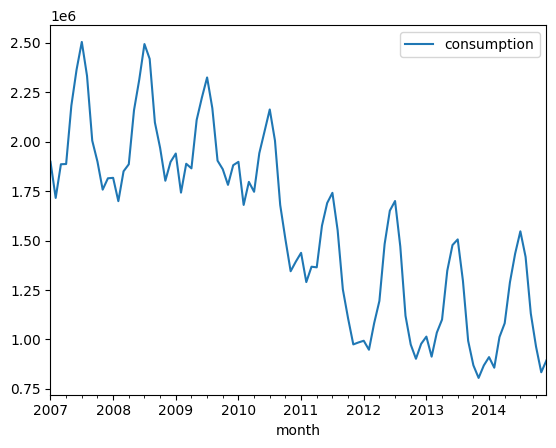

In [25]:
solar.plot()



The above plot shows trend and seasonality. So, it's Non-stationary

Let's try the ACDF test now. In this method, we take a null hypothesis that the data is non-stationary. If the test statistic is less than the critical value then we can reject the null hypothesis and say that the series is stationary.


In [26]:
# Augmented Dickey-fuller test

from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(solar['consumption'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                 -1.421653
p-value                         0.571853
#lags used                     12.000000
number of observations used    83.000000
critical value (1%)            -3.511712
critical value (5%)            -2.897048
critical value (10%)           -2.585713
dtype: float64




From the above, we see that the test statistic is greater than the critival value. Hence we fail to reject the Null hypothesis. So, the data is Non-stationary.

We can try another method called - Rolling statistics. This method gives a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plotted and then it is observed whether it varies with time or not. In this method, a moving window of time is taken (based on our needs, for eg-10, 12, etc.) and then the mean of that time period is calculated as the current value.


             consumption
month                   
2007-01-01           NaN
2007-02-01           NaN
2007-03-01           NaN
2007-04-01           NaN
2007-05-01           NaN
...                  ...
2014-08-01  1.090279e+06
2014-09-01  1.101785e+06
2014-10-01  1.109655e+06
2014-11-01  1.112039e+06
2014-12-01  1.114200e+06

[96 rows x 1 columns]               consumption
month                    
2007-01-01            NaN
2007-02-01            NaN
2007-03-01            NaN
2007-04-01            NaN
2007-05-01            NaN
...                   ...
2014-08-01  262022.349650
2014-09-01  260378.222000
2014-10-01  254055.067612
2014-11-01  251053.751085
2014-12-01  248865.828053

[96 rows x 1 columns]


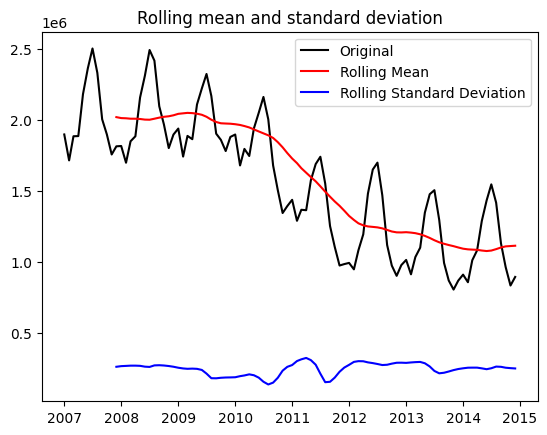

In [27]:
rmean=solar.rolling(window=12).mean()
rstd=solar.rolling(window=12).std()
print(rmean,rstd)
orig=plt.plot(solar , color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

1. Rolling Mean:

A constant horizontal line indicates a stationary series with no overall increasing or decreasing tendency.
If the rolling mean has an upward or downward slope, it suggests a non-stationary trend in the data. The presence of a trend would violate the stationarity assumption of ARIMA models.

2. Rolling Standard Deviation:

A consistent range in the rolling standard deviation line indicates that the variability of the data remains constant over time. This is a desirable characteristic for a stationary time series.
If the rolling standard deviation fluctuates significantly, it might indicate non-constant variance in the data, which can also violate stationarity assumptions.


Decomposing the series and looking at the components, a clear seasonality is observed.



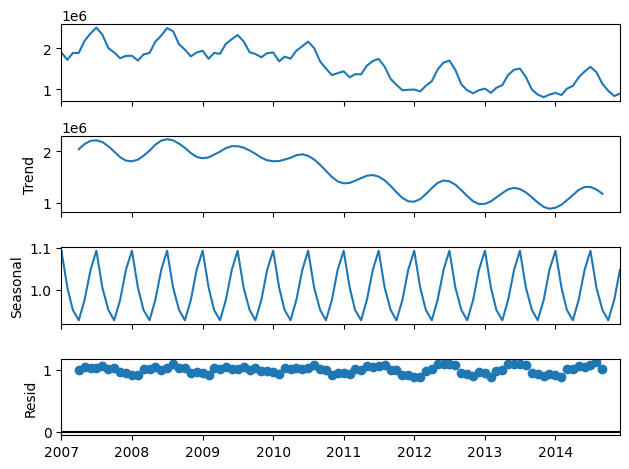

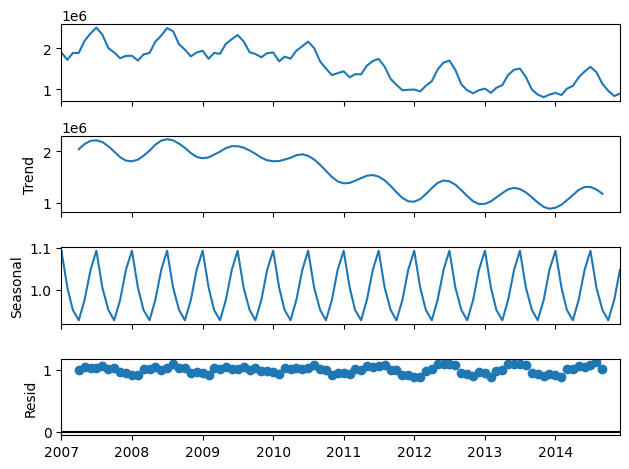

In [28]:
seasonal_decompose(solar, period=6, model='multiplicative').plot()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


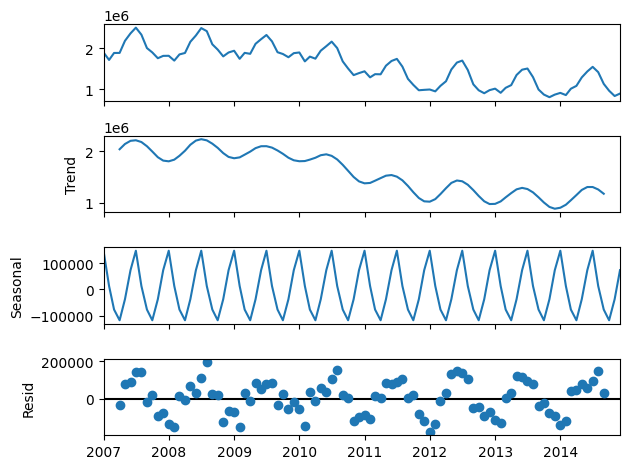

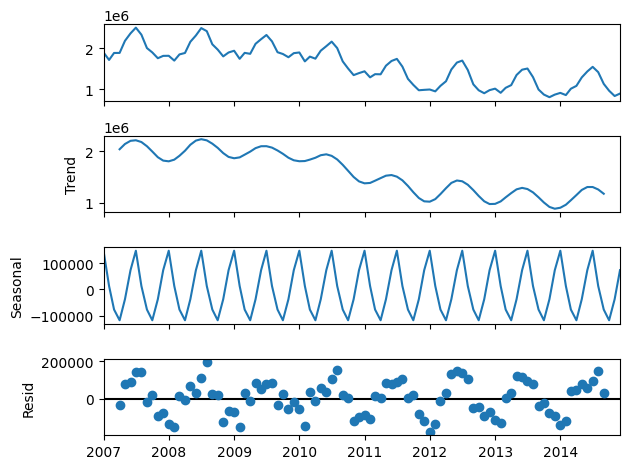

In [29]:
seasonal_decompose(solar, period=6, model='additive').plot()

#### Determining parameters for the SARIMA model

Since clear seasonality is observed in the data, we will use the SARIMA model (instead of the ARIMA model).

- p is the number of autoregressive terms,
- d is the number of nonseasonal differences,
- q is the number of lagged forecast errors in the prediction equation.

Based on the ACF and PACF plats below, the values of p and q are as follows:
- p = 6
- q = 2

d should be nonzero for nonstationary series. To determine optimal d value, we can try modeling with 1 and 2 values and see which one performs better.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


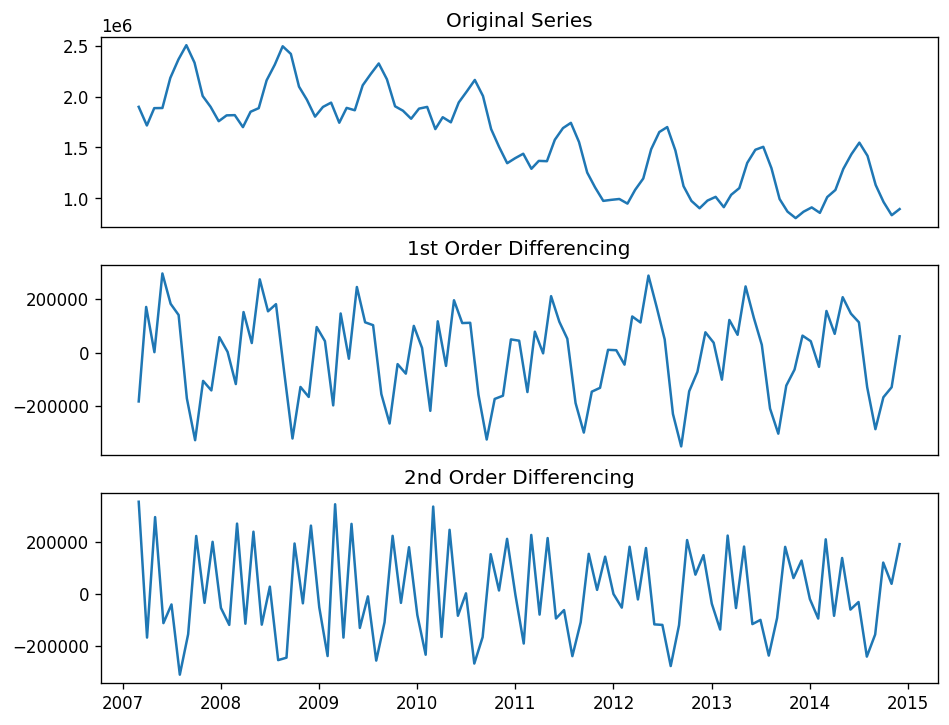

In [30]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(solar.consumption); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(solar.consumption.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(solar.consumption.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

We can notice here that in first-order differencing we have fewer noises in the data while after 1st order there is an increase in the noise. So we can select 1st order differencing for our model. We can also verify this using an autocorrelation plot.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

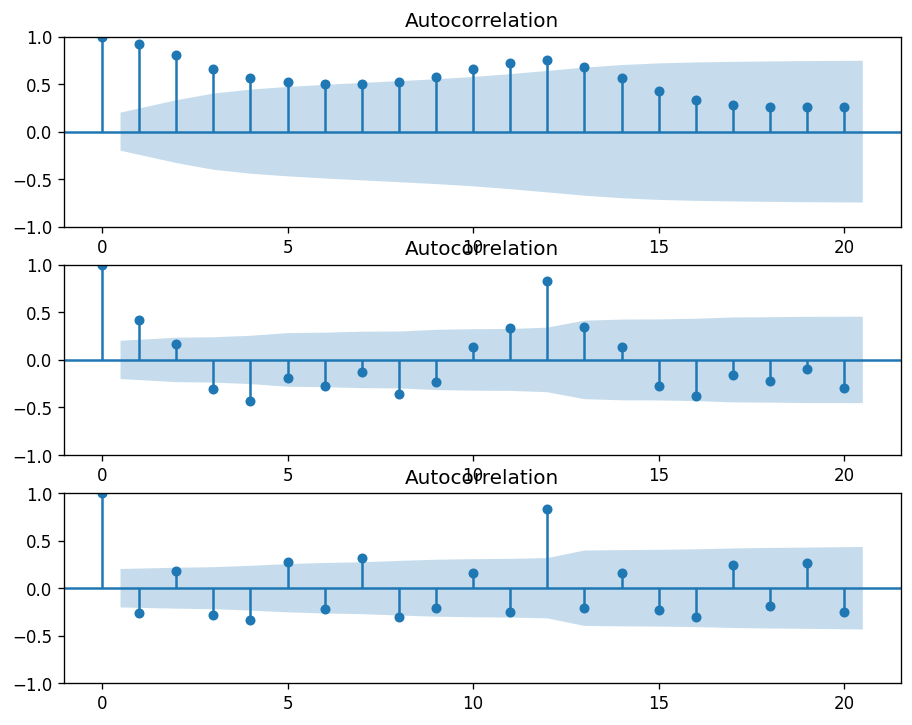

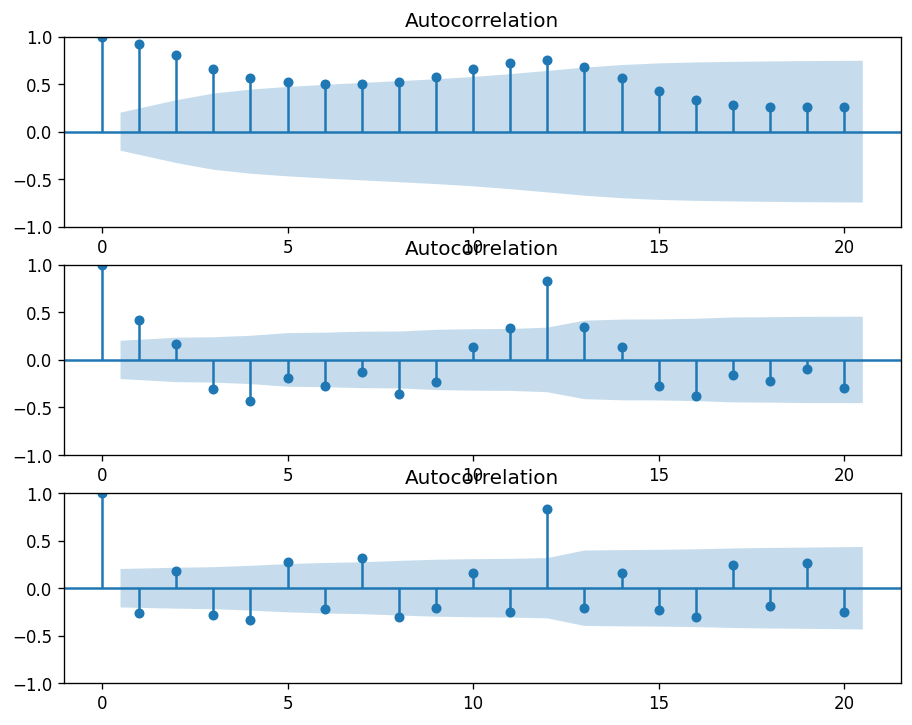

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(solar.consumption, ax=ax1)
plot_acf(solar.consumption.diff().dropna(), ax=ax2)
plot_acf(solar.consumption.diff().diff().dropna(), ax=ax3)

Here we can see that in second-order differencing the immediate lag has gone on the negative side, representing that in the second-order the series has become over the difference.

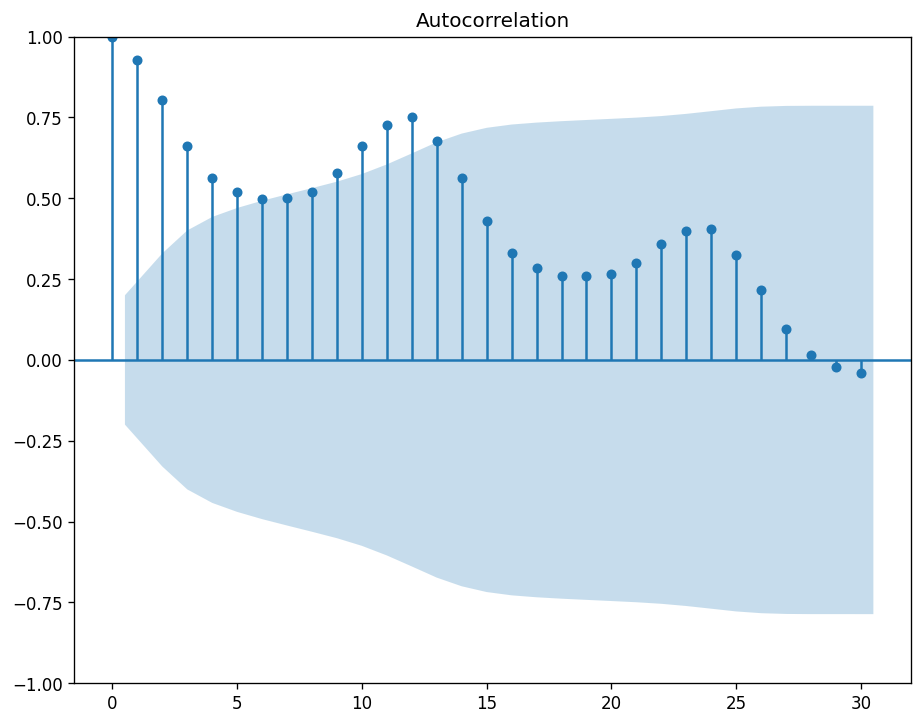

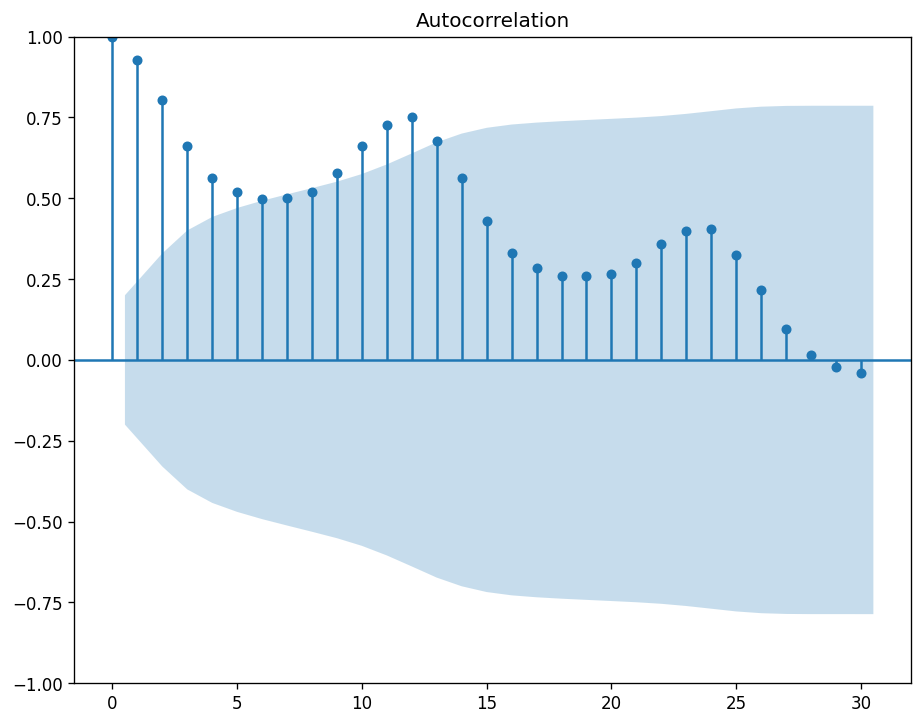

In [32]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(solar['consumption'], lags=30)


#### Interpreting ACF plots
ACF plot is used to identify the AR term (p) of the SARIMA model by looking for the number of lags with significant spikes.
Spikes beyond the shaded area are considered significant.
From the above, the appropriate p value can be 5.
The AR term refers to the number of past lags that should be included in the model.

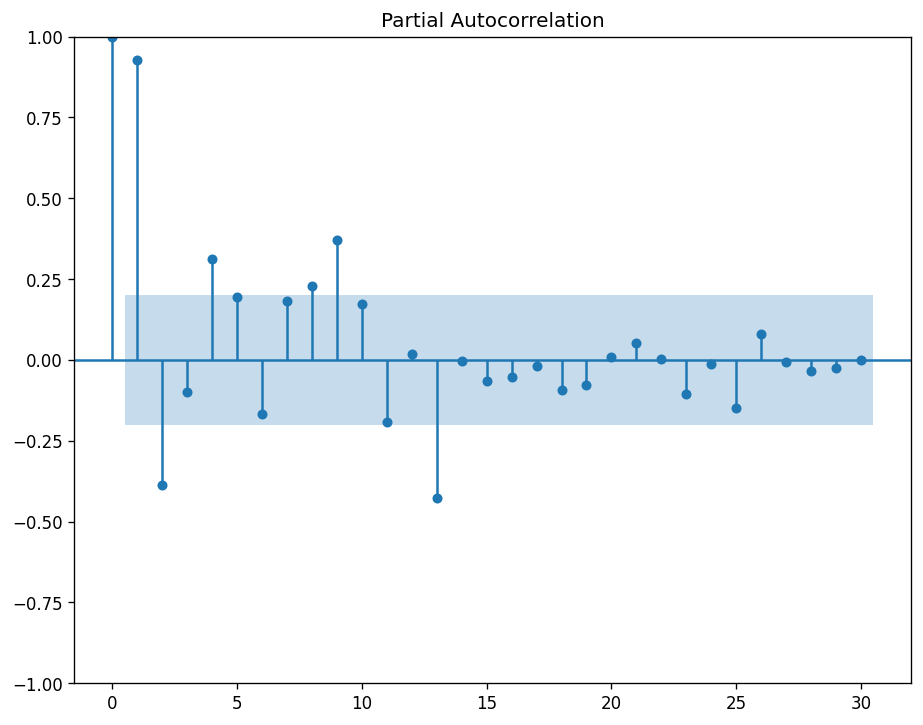

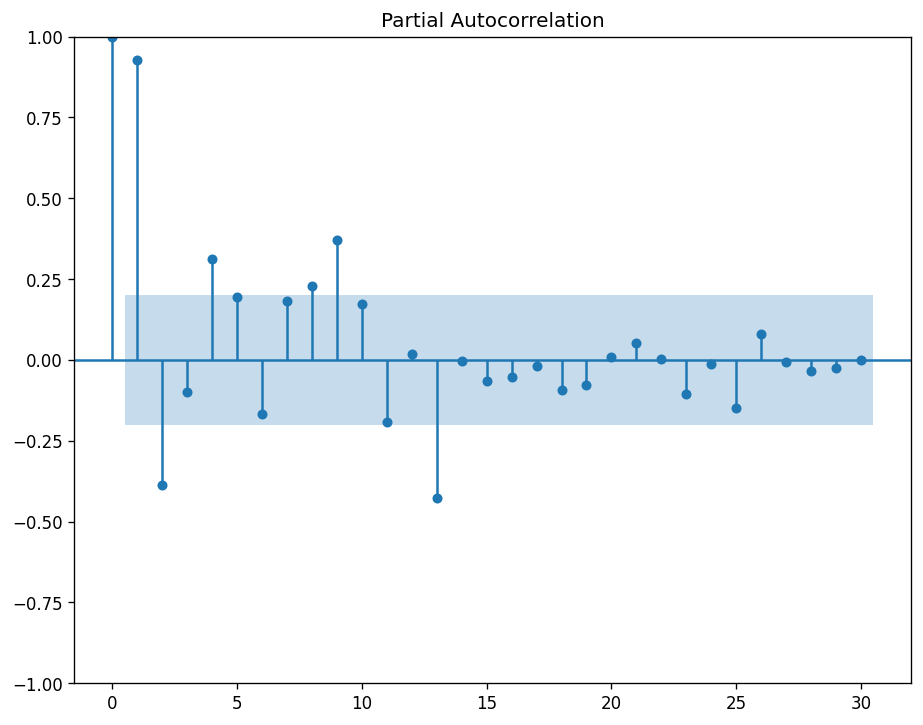

In [33]:
plot_pacf(solar['consumption'], lags=30)

#### Interpreting PACF plots
PACF plot is used to identify the MA term (q) of the SARIMA model by looking for the number of lags with significant spikes.
From the above, we can determine that the appropriate q parameter value can be 2.
The MA term refers to the number of past residuals (errors) that should be included in the model.

Trying seasonal decomposition to see if we can make the data stationary

In [34]:
from statsmodels.tsa.seasonal import STL

# Seasonal decomposition
stl = STL(solar['consumption'], seasonal=7)
stl_result = stl.fit()
deseasonalized_data = solar['consumption'] - stl_result.seasonal

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(deseasonalized_data,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                 -0.676345
p-value                         0.852782
#lags used                      3.000000
number of observations used    92.000000
critical value (1%)            -3.503515
critical value (5%)            -2.893508
critical value (10%)           -2.583824
dtype: float64


The test statistic is greater than the critical value, so the series is still nonstationary.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


month
2007-01-01             NaN
2007-02-01             NaN
2007-03-01             NaN
2007-04-01             NaN
2007-05-01             NaN
                  ...     
2014-08-01    1.088789e+06
2014-09-01    1.099954e+06
2014-10-01    1.108404e+06
2014-11-01    1.111595e+06
2014-12-01    1.114685e+06
Length: 96, dtype: float64 month
2007-01-01             NaN
2007-02-01             NaN
2007-03-01             NaN
2007-04-01             NaN
2007-05-01             NaN
                  ...     
2014-08-01    30302.820868
2014-09-01    34263.858963
2014-10-01    36030.198127
2014-11-01    36225.062279
2014-12-01    36277.441321
Length: 96, dtype: float64


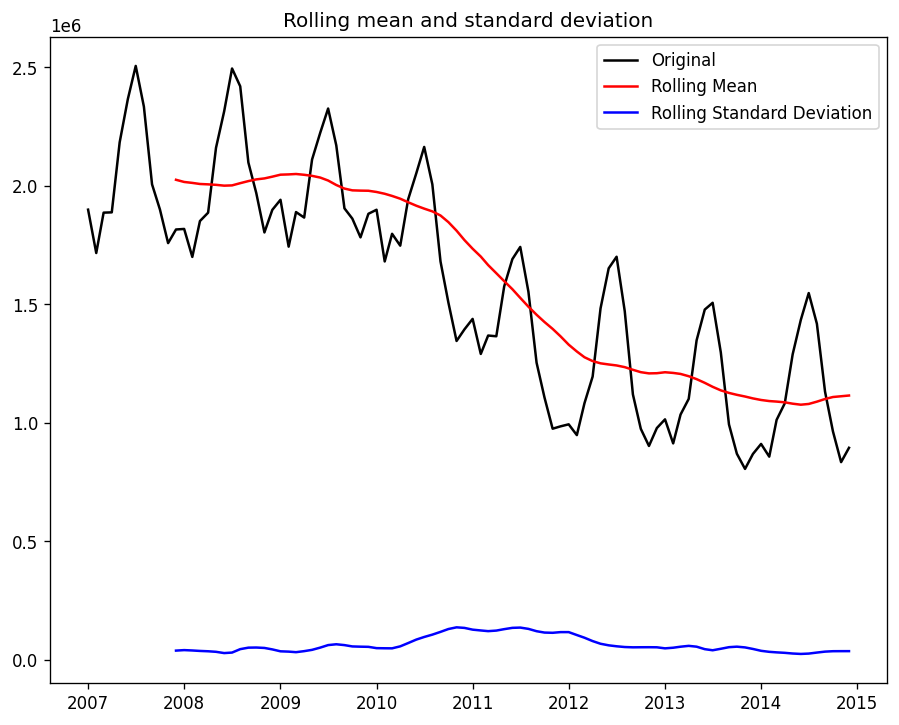

In [36]:
rmean=deseasonalized_data.rolling(window=12).mean()
rstd=deseasonalized_data.rolling(window=12).std()
print(rmean,rstd)
orig=plt.plot(solar , color='black',label='Original')
mean= plt.plot(rmean , color='red',label='Rolling Mean')
std=plt.plot(rstd,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.show(block=False)

Seasonal decomposition did not make the data stationary.


Splitting into train and test data

In [37]:
train_size = int(len(solar) * 0.8)  # 80% train, 20% test
train_data, test_data = solar.iloc[:train_size], solar.iloc[train_size:]

end_train = '2012-12-01'

data_train = solar.loc[:end_train, :].copy()
data_test  = solar.loc[end_train:, :].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")

Train dates      : 2007-01-01 00:00:00 --- 2012-12-01 00:00:00  (n=72)


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [39]:
sarima_model = SARIMAX(data_train, order=(5, 1, 2), seasonal_order=(1, 1, 5, 12))
sarima_fit = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/d

In [40]:
forecast = sarima_fit.get_forecast(steps=12)
# steps = 12

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


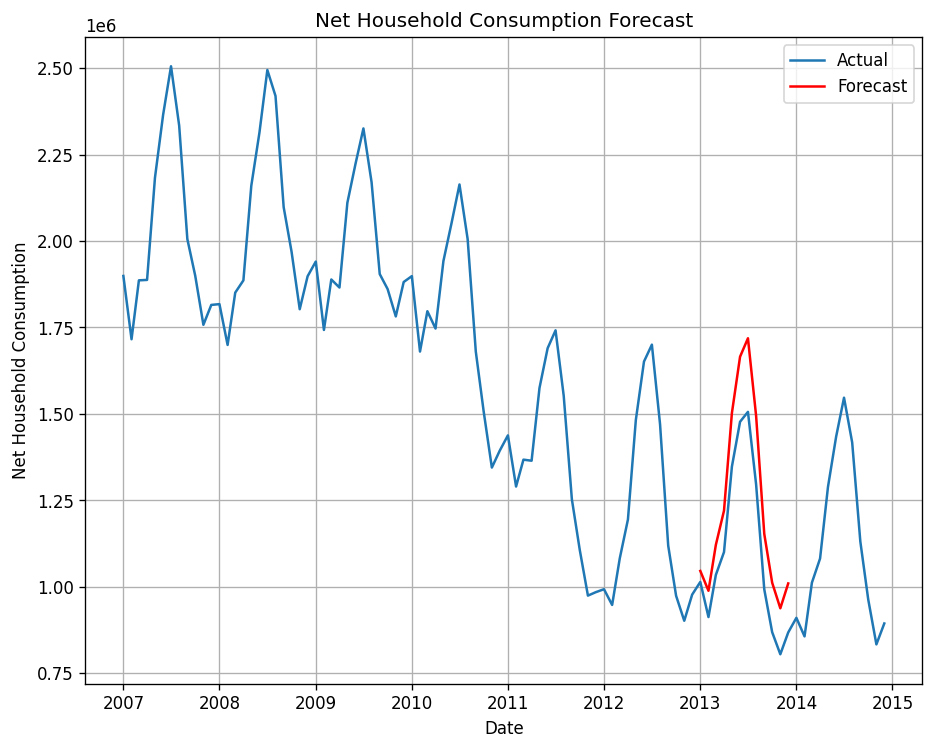

In [41]:
plt.plot(solar.index, solar, label='Actual')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.title('Net Household Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Net Household Consumption')
plt.legend()
plt.grid(True)
plt.show()

Evaluating the model

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

forecasted_values = forecast.predicted_mean

actual_values = test_data.iloc[:len(forecasted_values)].values

mae = mean_absolute_error(actual_values, forecasted_values)
rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
#mape = np.mean(np.abs((actual_values - forecasted_values) / actual_values)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
#print("Mean Absolute Percentage Error (MAPE):", mape)



<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Mean Absolute Error (MAE): 386720.8152868522
Root Mean Squared Error (RMSE): 474152.3898480315


#### Metrics
MAPE - Mean Absolute Percentage Error is the percentage equivalent of mean absolute error (MAE). It is calculated as (|Actual Value - Forecast Value| / Actual Value) * 100
It is a scale-independent metric and is easier to interpret compared to MAE, MSE, or RMSE. However, it is asymmetric and downwardly biased. Doesn't pernalize  large errors proportionally more than small errors.
MAPE is ideal in the cases where there are little to no: outliers, values near zero, values at zero, and low volume / sparse datasets.

sMAPE (Symmetric MAPE) - It addresses the zero-division issue of MAPE by using the average of the forecast and actual value as the denominator instead of just the actual value. (|Actual Value - Forecast Value| / (|Actual Value| + |Forecast Value|)/2) * 100, averaged across all periods. It is symmetrical, meaning both over-forecasts and under-forecasts are penalized equally. It is less intuitive to interpret compared to MAPE. Can still be sensitive to outliers, although to a lesser extent than MAPE.

wMAPE (Weighted MAPE) and WAPE are weighted forms of the core metrics, and can be used if certain forecasts are more important than the others.However, leveragin these metrics implies determining the appropriate weights to use.

At first glance, sMAPE might be a better metric to use. However sMAPE is not intuitive to interpret. Also, it is considered less symmetric than its name suggests and may not estimate meaningful statistics like the mean or median of the distribution. sMAPE penalizes underestimates more than overestimates for the same actual value, potentially favoring slightly overestimating models.

#### Choosing the right metric
The best choice of metric depends on various factors such as the characteristics of the time series, user expectations, and business utility. Different error measures optimize for specific statistics of the distribution, like mean or median, with measures like MSE and RMSE optimizing for the mean, while MAE and MASE optimize for the median.

Studies indicate that it is important to consider multiple error measure for model optimization and evaluation.

In [43]:
print("Length of test_data:", len(data_test))

# Check the length of forecasted_values
print("Length of forecasted_values:", len(forecasted_values))

# Extract actual values from the test set
actual_values = data_test.iloc[:len(forecasted_values)].values
print("Length of actual_values:", len(actual_values))


Length of test_data: 25
Length of forecasted_values: 12
Length of actual_values: 12


In [44]:
import numpy as np

def calculate_mape(actual, forecast):

    actual = np.array(actual_values)
    forecast = np.array(forecasted_values)

    abs_percentage_error = np.abs((actual - forecast) / actual)

    abs_percentage_error = abs_percentage_error[~np.isnan(abs_percentage_error) & ~np.isinf(abs_percentage_error)]

    mape = np.mean(abs_percentage_error) * 100

    return mape




In [45]:

flattened_data = actual_values.ravel()

flattened_forecast = forecasted_values.ravel()

mape = calculate_mape(flattened_data, flattened_forecast)
print(mape)

27.997555932074015


In [46]:
#Calculate sMAPE

def calculate_smape(actual, predicted) -> float:

    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray),
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)

    return round(
        np.mean(
            np.abs(predicted - actual) /
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

smape = calculate_smape(flattened_data, flattened_forecast)
print(smape)

13.16


#### Try Grid search to determine right parameters

In [47]:
## Grid search code placeholder

from itertools import product
import warnings

# Define the parameter grid
P = [0, 1, 2]
D = [0, 1]
Q = [0, 1, 2, 3, 4, 5]
s = 12

best_mape = float('inf')
best_rmse = float('inf')
best_params = None

# Iterate over all combinations of seasonal parameters
for (p_seasonal, d_seasonal, q_seasonal) in product(P, D, Q):
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            sarima_model = SARIMAX(data_train, order=(5, 1, 2),
                                   seasonal_order=(p_seasonal, d_seasonal, q_seasonal, s))
            sarima_fit = sarima_model.fit(disp=False)


        forecast = sarima_fit.get_forecast(steps=12)
        forecasted_values = forecast.predicted_mean


        actual_values = data_test.iloc[:len(forecasted_values)].values


        mae = mean_absolute_error(actual_values, forecasted_values)
        rmse = np.sqrt(mean_squared_error(actual_values, forecasted_values))
        mape = calculate_mape(actual_values, forecasted_values)

        if mape < best_mape and rmse < best_rmse:
            best_mape = mape
            best_rmse = rmse
            best_params = (p_seasonal, d_seasonal, q_seasonal)

        print(f"SARIMA(5, 1, 2) x ({p_seasonal}, {d_seasonal}, {q_seasonal}, {s}) - MAPE: {mape:.3f}, RMSE: {rmse:.3f}")
    except Exception as e:
        print(f"An error occurred for parameters ({p_seasonal}, {d_seasonal}, {q_seasonal}, {s}): {e}")

# Print the best parameters
print(f"Best Parameters: {best_params} - MAPE: {best_mape:.3f}, RMSE: {best_rmse:.3f}")


SARIMA(5, 1, 2) x (0, 0, 0, 12) - MAPE: 23.667, RMSE: 365262.862
An error occurred for parameters (0, 0, 1, 12): LU decomposition error.
SARIMA(5, 1, 2) x (0, 0, 2, 12) - MAPE: 16.544, RMSE: 187509.107
SARIMA(5, 1, 2) x (0, 0, 3, 12) - MAPE: 16.895, RMSE: 188623.833
SARIMA(5, 1, 2) x (0, 0, 4, 12) - MAPE: 17.734, RMSE: 226727.864
SARIMA(5, 1, 2) x (0, 0, 5, 12) - MAPE: 20.969, RMSE: 275992.333
SARIMA(5, 1, 2) x (0, 1, 0, 12) - MAPE: 27.016, RMSE: 181620.167
SARIMA(5, 1, 2) x (0, 1, 1, 12) - MAPE: 27.098, RMSE: 181949.518
SARIMA(5, 1, 2) x (0, 1, 2, 12) - MAPE: 26.818, RMSE: 177125.087
SARIMA(5, 1, 2) x (0, 1, 3, 12) - MAPE: 26.902, RMSE: 177736.055
SARIMA(5, 1, 2) x (0, 1, 4, 12) - MAPE: 26.953, RMSE: 178725.667
SARIMA(5, 1, 2) x (0, 1, 5, 12) - MAPE: 27.720, RMSE: 193571.381
SARIMA(5, 1, 2) x (1, 0, 0, 12) - MAPE: 16.922, RMSE: 176259.184
SARIMA(5, 1, 2) x (1, 0, 1, 12) - MAPE: 22.077, RMSE: 154456.620
SARIMA(5, 1, 2) x (1, 0, 2, 12) - MAPE: 21.792, RMSE: 159587.634
SARIMA(5, 1, 2) x 

In [48]:
# Install the library if necessary
!pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(data_train,
                   seasonal=True,
                   m=12,
                   suppress_warnings=True)
model.fit(data_train)

# Check the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -938.668
Date:                              Fri, 31 May 2024   AIC                           1887.336
Time:                                      23:06:25   BIC                           1898.649
Sample:                                  01-01-2007   HQIC                          1891.835
                                       - 12-01-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0434      0.040      1.087      0.277      -0.035       0.122
ma.L2          0.0968      0.179      0.540      0.589      -0.254       0.448
ar.S.L12       0.8426      0.132      6.373      0.000       0.583       1.102
ma.S.L12      -0.6854      0.169     -4.058      0.000      -1.016      -0.354
sigma2      2.092e+10   3.51e-12   5.96e+21      0.000    2.09e+10    2.09e+10
===================================================================================
Ljung-Box (L1) (Q):                   7.31   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.01   Prob(JB):                         0.57
Heteroskedasticity (H):               0.31   Skew:                            -0.30
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.3e+37. Standard errors may be unstable.
"""

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define the SARIMAX model with parameters from auto_arima
sarima_model_auto = SARIMAX(data_train, order=(0, 1, 2), seasonal_order=(1, 0, 1, 12))
sarima_fit_auto = sarima_model_auto.fit(disp=False)

# Forecast using the fitted model
forecast_auto = sarima_fit_auto.get_forecast(steps=12)
forecasted_values_auto = forecast_auto.predicted_mean

# Align actual values
actual_values = data_test.iloc[:len(forecasted_values_auto)].values

# Calculate error metrics
mae_auto = mean_absolute_error(actual_values, forecasted_values_auto)
rmse_auto = np.sqrt(mean_squared_error(actual_values, forecasted_values_auto))
mape_auto = calculate_mape(actual_values, forecasted_values_auto)


print(f"SARIMAX(0, 1, 2)x(1, 0, 1, 12) - MAPE: {mape_auto:.3f}, RMSE: {rmse_auto:.3f}")

# Compare with the best parameters from grid search
print(f"Best Parameters from Grid Search: {best_params} - MAPE: {best_mape:.3f}, RMSE: {best_rmse:.3f}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


SARIMAX(0, 1, 2)x(1, 0, 1, 12) - MAPE: 27.672, RMSE: 149027.037
Best Parameters from Grid Search: (0, 0, 2) - MAPE: 16.544, RMSE: 187509.107


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The best MAPE and RMSE values got for the parameters Non-Seasonal Parameters:
p=5
d=1
q=2
Seasonal Parameters:
P=0
D=0
Q=2 (seasonal MA term at lag 12)

#Forecasting with XGBoost

In [50]:
df_xg = solar_net_consumption.copy()

In [52]:
df_xg.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Customer ID,Consumption Month,consumption
0,1,2007-01-01,590.240
1,1,2007-02-01,670.667
2,1,2007-03-01,742.524
3,1,2007-04-01,786.290
4,1,2007-05-01,1092.402


In [53]:
def create_lag_features(data, lag_steps):
    for lag in range(1, lag_steps + 1):
        data[f'lag_{lag}'] = data.groupby('Customer ID')['consumption'].shift(lag)
    return data

df_long = create_lag_features(df_xg, lag_steps=3)


In [56]:
def create_rolling_mean_features(data, window_size):
    data['rolling_mean'] = data.groupby('Customer ID')['consumption'].transform(lambda x: x.shift(1).rolling(window=window_size).mean())
    return data

df_long = create_rolling_mean_features(df_long, window_size=2)

In [57]:
df_long.fillna(method='bfill', inplace=True)

In [58]:
df_long['Consumption Month'] = pd.to_datetime(df_long['Consumption Month'])

In [60]:

split_date = '2014-12-01'

# Split the data
train_data_xg = df_long[df_long['Consumption Month'] < split_date]
test_data_xg = df_long[df_long['Consumption Month'] == split_date]

# Separate features and target
X_train_xg = train_data_xg.drop(columns=['Customer ID', 'Consumption Month', 'consumption'])
y_train_xg = train_data_xg['consumption']

X_test_xg = test_data_xg.drop(columns=['Customer ID', 'Consumption Month', 'consumption'])
y_test_xg = test_data_xg['consumption']

In [61]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    learning_rate=0.05,
    max_depth=5,
    subsample=1.0,
    colsample_bytree=0.8,
    n_estimators=300
)

xgb_model.fit(X_train_xg, y_train_xg)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:

predictions = xgb_model.predict(X_test_xg)

def calculate_mape(actual, forecast):
    threshold = 0
    mask = actual > 0
    actual, forecast = actual[mask], forecast[mask]

 # Calculate MAPE
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mape

def calculate_smape(actual, predicted):
    return np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted))) * 100

# Calculate rmse
rmse = np.sqrt(mean_squared_error(y_test_xg, predictions))
print(f'Root Mean Squared Error (rmse): {rmse:.2f}')

# Calculate MAPE
mape = calculate_mape(y_test_xg, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}')

# Calculate sMAPE
smape = calculate_smape(y_test_xg, predictions)
print(f'Symmetric Mean Absolute Percentage Error (sMAPE): {smape:.2f}')


Root Mean Squared Error (rmse): 101.36
Mean Absolute Percentage Error (MAPE): 40.54
Symmetric Mean Absolute Percentage Error (sMAPE): 25.24


#Inference

We've opted to deploy the XGBoost model due to its balanced performance across multiple metrics. Compared to SARIMA, where the RMSE is excessively high while MAPE and SMAPE are low, XGBoost demonstrates a more consistent performance with a lower RMSE and slightly higher MAPE and SMAPE. Considering the moderate nature of all metrics in the XGBoost model, it is our preferred choice for deployment.